In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import struct
%matplotlib widget

Creates initial random data in frequency domain. N is the max number of samples, while M is the samples being populated with random data

In [2]:
N = 64 # NUmber of samples in the waveform, user defined
Nbits = 14
T = 16
# N = 128 ### worked with aaron


def gen_flat_spectrum_waveform(N=64, seed=0):
    """
    Return a waveform with hermitian spectrum with random phases and unity amplitude
    """
    M = (N//2)-1 # number of noise samples to draw
    
    d_tilda = np.zeros(N) + 1j*np.zeros(N)
    # print(d_tilda.shape)
    
    np.random.seed(seed)
    dM_tilda =   np.exp(1j*np.random.uniform(0, 2*np.pi, size=M))
    conj_dM = np.conjugate(dM_tilda)[::-1]
    # print(dM_tilda.shape , conj_dM.shape)
    # print(d_tilda[1:M+1].shape)
    d_tilda[1:M+1] = dM_tilda
    d_tilda[-M:] = conj_dM
    d = np.fft.ifft(d_tilda)
    return d.real

def round_waveform(d, nbits=14, scale=1.0):
    d_scale = scale * d.real / np.max(np.abs(d.real)) * (2**(nbits - 1) - 1)
    #d_int = np.floor(d_scale).astype(int)
    #remainder = d_scale - d_int
    #odd = d_int % 1
    #do_round = np.where(remainder > 0.5, 1, np.where(remainder < 0.5, 0, odd))
    #d_int += do_round
    d_int = np.round(d_scale)
    return d_int.astype(int)

def tile_waveform(d, T=16):
    d_repeat = np.tile(d, T)
    return d_repeat

def pack_waveform(d_repeat):
    d_pack = d_repeat * 4
    pr = struct.pack(f'>{d_pack.size}h', *d_pack)
    return pr

Inverse fourier transform the random data. d_int is the resulting data turned into intergers under 14 bits, the max value of the DAC on the Red Pitaya

816343 2.0100859204113696e-10
-3.0357660829594124e-18 0.046875


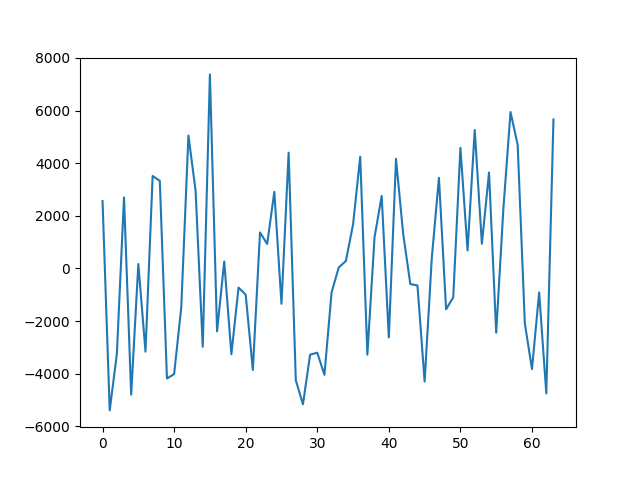

In [126]:
goal_spec = np.zeros_like(repeat_fft)
goal_spec[T::T] = 1
goal_spec[N*T//2] = 0

best_seed = 152063
best = 2.1635e-10
for seed in range(200000, 2000000):
    d = gen_flat_spectrum_waveform(N, seed=seed)
    d_back = np.fft.fft(d)
    d_int = round_waveform(d, nbits=Nbits, scale=.9)
    d_repeat = tile_waveform(d_int, T)
    repeat_fft = np.fft.fft(d_repeat)
    p_spec = np.abs(repeat_fft)**2
    peak = np.mean(p_spec[T:12*T:T])
    p_spec /= peak
    score = np.mean(np.abs(p_spec - goal_spec)**2)
    if score < best:
        print(seed, score)
        best = score
#peak = 1
print(np.mean(d), np.mean(d_int))

plt.figure()
# plt.plot(d.real)
# plt.plot(d.imag)
plt.plot(d_int.real)
# plt.plot(d_int.imag)
# plt.plot(freq, np.fft.fftshift(np.abs(d_tilda)))
# plt.plot(freq, np.fft.fftshift(np.abs(d_back)), linestyle='--')
# plt.plot(freq, np.abs(np.fft.fftshift(d_tilda)))
plt.show()

In [3]:
better_seed = 816343

d = gen_flat_spectrum_waveform(N, seed=better_seed)
d_back = np.fft.fft(d)
d_int = round_waveform(d, nbits=Nbits, scale=.9)
d_repeat = tile_waveform(d_int, T)
d_pack = pack_waveform(d_repeat)

In [141]:
bin(struct.unpack('>h', d_pack[:2])[0])


'-0b11010000101100'

In [148]:
print(struct.unpack('>h', d_pack[:2])[0])

-13356


In [108]:
# def sqrt(x):
    # return np.where(x < 0, 1j * np.sqrt(-x), np.sqrt(x))


Copies of the transformed data are repeated a T number of times, then Fourier transformed. Result is equally valued spikes seperated at T intervals 

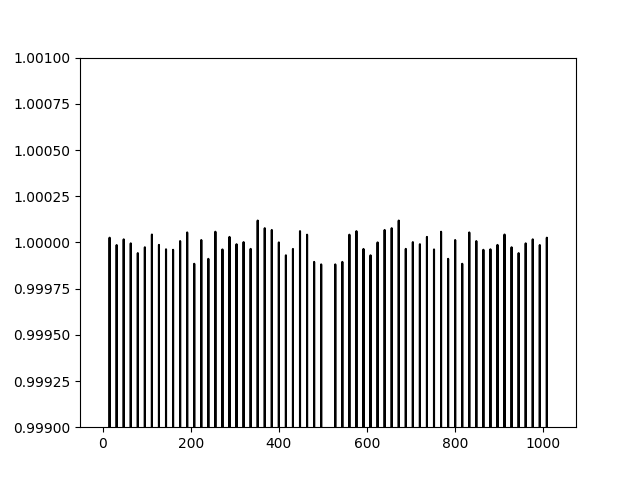

In [4]:
d_repeat_fft = np.fft.fft(d_repeat)
p_spec = np.abs(d_repeat_fft)**2
peak = np.mean(p_spec[T:12*T:T])
p_spec /= peak

freqs = np.fft.fftfreq(d_repeat.size)


plt.figure()
plt.plot(np.fft.fftshift(p_spec), color='black')
# plt.plot(np.fft.fftshift(goal_spec), color='red', alpha=0.5)
# plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(repeat_fft)), color='black')
plt.ylim(0.999, 1.001)
#plt.ylim(-1, 1)
plt.show()

The repeated data is then saved to be produced by the DAC

In [91]:
p_spec[T::T]

array([4.57790691e+08, 4.57823198e+08, 4.57940753e+08, 4.57864779e+08,
       4.57825698e+08, 4.57854477e+08, 4.57841811e+08, 4.57829831e+08,
       4.57904564e+08, 4.57745653e+08, 4.57818510e+08, 4.57857015e+08,
       4.57926149e+08, 4.57832737e+08, 4.57856209e+08, 4.57836586e+08,
       4.57918061e+08, 4.57871208e+08, 4.57903217e+08, 4.57874570e+08,
       4.57886646e+08, 4.57956302e+08, 4.57853461e+08, 4.57861981e+08,
       4.57911198e+08, 4.57914147e+08, 4.57868809e+08, 4.57831348e+08,
       4.57744492e+08, 4.57949239e+08, 4.57968546e+08, 4.00000000e+00,
       4.57968546e+08, 4.57949239e+08, 4.57744492e+08, 4.57831348e+08,
       4.57868809e+08, 4.57914147e+08, 4.57911198e+08, 4.57861981e+08,
       4.57853461e+08, 4.57956302e+08, 4.57886646e+08, 4.57874570e+08,
       4.57903217e+08, 4.57871208e+08, 4.57918061e+08, 4.57836586e+08,
       4.57856209e+08, 4.57832737e+08, 4.57926149e+08, 4.57857015e+08,
       4.57818510e+08, 4.57745653e+08, 4.57904564e+08, 4.57829831e+08,
      

In [18]:
saved_file = int_repeat
print(saved_file.shape) # Shape of the data should not exceed 1024, due to simulink design. Possible to increase?
print(T, N)
# np.save('/home/dominiv/simulink/dac/notebooks/d_int_repeat_64shift.npy', int_repeat.real)
np.savez(f'/home/dominiv/simulink/dac/notebooks/d_int_{T}set{N}sam.npz', data=saved_file) ### 16set64 is best

(1024,)
16 64


In [7]:
def spikes(n):
    N = 2 ** (n)
    M = (N // 2) - 1

    d_tilda = np.zeros(N) + 1j * np.zeros(N)

    dM_tilda = np.exp(1j * np.random.uniform(0, 2 * np.pi, size=M))
    conj_dM = np.conjugate(dM_tilda)[::-1]
    d_tilda[1:M+1] = dM_tilda
    d_tilda[-M:] = conj_dM
    d = np.fft.ifft(d_tilda)
    m = 16 - n
    T = 2 ** (abs(m))
    repeat = np.tile(d.real, T)
    maxVal = 2**14 - 1
    repeat *= maxVal

    repeat = np.round(np.short(repeat))

    repeat <<= 2

    plt.figure()
    plt.plot(repeat)
    plt.show()
    pr = bytes()
    for i in repeat.astype("int"):
        pr += struct.pack(">h", i)
    return pr

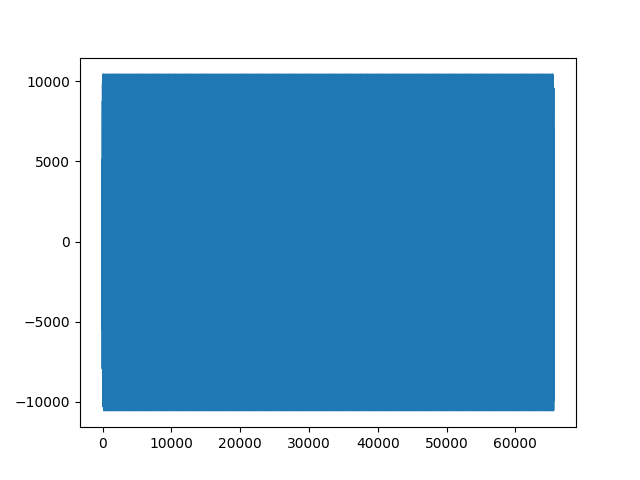

b'\xf58\xfeX\x04\x1c\x10\xa4\xf5\xbc\x01\xbc\x04\x18\xf1(\x14\x00\xe1\x08\x07\xcc\t\xac\t\xb8\x06\xe8\x00\xc0\x12\xd4\x02\xc4\xfa\xb4\n\x88\x08\x84\xf0\xf8\x0b\x8c\xfe$\xf6|\xfb8\xef\x18\xf6\xb0\x0eH\xf4\x00\xf1|\x01t\xf2X\n\\\x1e\xcc\xec\xe8\xea\x94\x06\x94\x0e\xc0\xfd`\xf1\xe4\xee(\xf1X\x06\x90\x03\xd4"@\xf7\xdc\xfch\x13\x8c\xf0\xd4\x08\xf8\x13\xf8\xf7t&\x8c\xfd\xb8\xf6$\x0b\xa8\xf8H\xf1p%X\x06\x00\xf1\x14\x03\xc0\xfb8\xf7\xa4\xf4\xb8\x02\x1c\xff\x00\x14H\x04P\xf3\xa0\xe7\x90\xf7\x0c\xfa\xdc\xfb\xf0\xff\xdc\xe6h \xd0\x00H\x0fp\xe7\xa8\x03\xe0\x02\xfc\r8\xe7\x94\xfc8\xe4\x0c\x07<\xf4\xe8\x17\x14\n\xfc\xf9<\x0e\xc0\n\x94\xf4\x10\x1b\xac\xfe\x94\x00$\x02\x08\x1f\xb4\n\x8c\xdd\xd0\x0c\xd0\r\xdc\x1d`\xf6\xb8\xfa|\x11\x14\xf2\x9c\xf0\xb0\xecD\xf7T\r\xec\xe5l\x15\xcc\xec\xd4(\xc0\xfcp\xd7\xc8\x18\xe4&x\x0c0\x11x\x06\x14\xe6\x10\x01\x9c\x16x\x15\xa0\xe5\xbc\xefX\xfd\xbc\xea<\x03\x1c\x08x\x07\x98\x0f\x90\xfbT\xf1\xe4\x18H\n\xdc\x19x\xf0<\xf9\xf0\xf40\xee\xb4\xfb\xb4\x08\xe0\x03T\xfat\x1d\x84\

In [10]:
spikes(8)